# Read imzML into XLSX

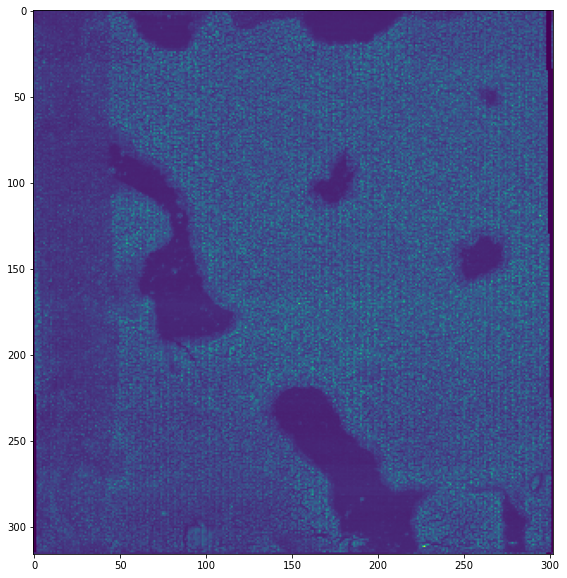

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xlsxwriter
from imzmlparser import ImzMLParser,_bisect_spectrum
from coregistration_metrics import getmaxmin,record_reader
# add getspectum, kmeans, correlation?   

MALDI_path = "/Volumes/Kemp/Arina/Li Li-Stem Cell Imaging/20180407_day4/20180407_day4_box 5_RN50/20180407_day4_box 5_RN50.imzML"
p = ImzMLParser(MALDI_path)
output_folder = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/maldi"
if not os.path.exists(output_folder): os.mkdir(output_folder)
xmax, xmin, ymax, ymin = getmaxmin(p)
ions = [883.576,885.573,887.57,913.597,915.594,940.592]
# peak widths, values get summed from ion-tolerance to ion+tolerance
tolerances = [0.3]*len(ions)
record_reader([xmin,ymin,ymax,xmax],p,output_folder,ions,tolerances)

# Alignment - setting up paths and parameters

In [5]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.optimize import dual_annealing
import os
from skimage.filters import median, gaussian, threshold_local
from skimage.morphology import disk, label
import xlsxwriter
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import random
from coregistration_metrics import transform_image,visualize,on_edge,edgeDistance,ClusterImage,overlay_cells,crop
from coregistration_metrics import mutual_information,getimagedimsfromexcel,readimagefromexcel,cleanup,relabel_random
from coregistration_metrics import get_connection_length

ions = [883.576,885.573,887.57,913.597,915.594,940.592]
# declaring INPUT files' paths 
maldi_folder_path = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/maldi" # folder with all the MALDI ion images to be co-registered
confocal_folder_path = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/confocal" # folder with confocal images of different channels to be co-registered
confocal_filename = confocal_folder_path+"/dapi.tif" # path to a representative confocal image for alignment 
                                                    # usually your Hoechst stained channel, 
                                                    # but could be any other channel with prominent colony outlines
maldi_filename = maldi_folder_path+"/average.png" # path to a representative MALDI ion image for alignment
                                                  # the "create ion images.py" in the folder provides you with an averaged
                                                  # ion image which usually should be representative enough
# designating OUTPUT folders and filenames
maldi_output_path = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/maldi aligned" # folder where all the MALDI ion images aligned with confocal will be saved
crop_confocal_path = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/cropped_confocal" # folder where cropped confocal images will be saved
metrics_output_folder = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/metrics" # scatterplots with output intensities
xlsx_output_name = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/cells.xlsx" # excel file path where co1-registered data will be saved (m/z and confocal signals with X and Y coordinates)
metrics_output_name = "/Volumes/Kemp/Arina/new_MALDI_experiment_Arina/day4box5/metrics.csv" # excel file path where all the calculated metrics will be saved

# initial ALIGNMENT parameters rotation (radians), x shift, y shift, scale
# you may or may not adjust it, the algorithm does not require it
maldi_pixel_size_um = 10
confocal_pixel_size_um = 0.72
xopt = [0,0,0,1] #(radians), x shift, y shift, scale
#setting boundaries for alignment parameters 
# the algorithm will look for a solution in parameter space bound by parameter+- parameter range
angle_range, x_range, y_range,scale_range = 0.01,100,100,0.01
maxiter = 1000 # maximum iteration number for the alignment algorithm
               # if alignment does not work, increase this number to 10000 or more
# Segmentation parameters
IntensityBlurRad = 0.5
DistanceBlurRad = 1.5
RadThr = 501 # size of the window for local thresholding, decrease if not enough cells are picked up. must be odd
Thr = 1 # noise level. increase for noisy images

# METRIC CALCULATION PARAMETERS
metrics_range = 5 # radius of cell interactions. Your cell-by-cell interaction will reach that many cells away 
edge_margin = 50 # you don't want cells on the edge of the image be automatically assigned to the edge of the colony, 
                # so here you define an image margin (in pixels) 
num_value_layers = 3 # number of intensity layers to split your variables for spatial clustering
min_clust_size = 5 # minimal number of cells to consider a cluster

# All user-defined parameters are declared above!

## Loading, processing and size-matching of images for alignment

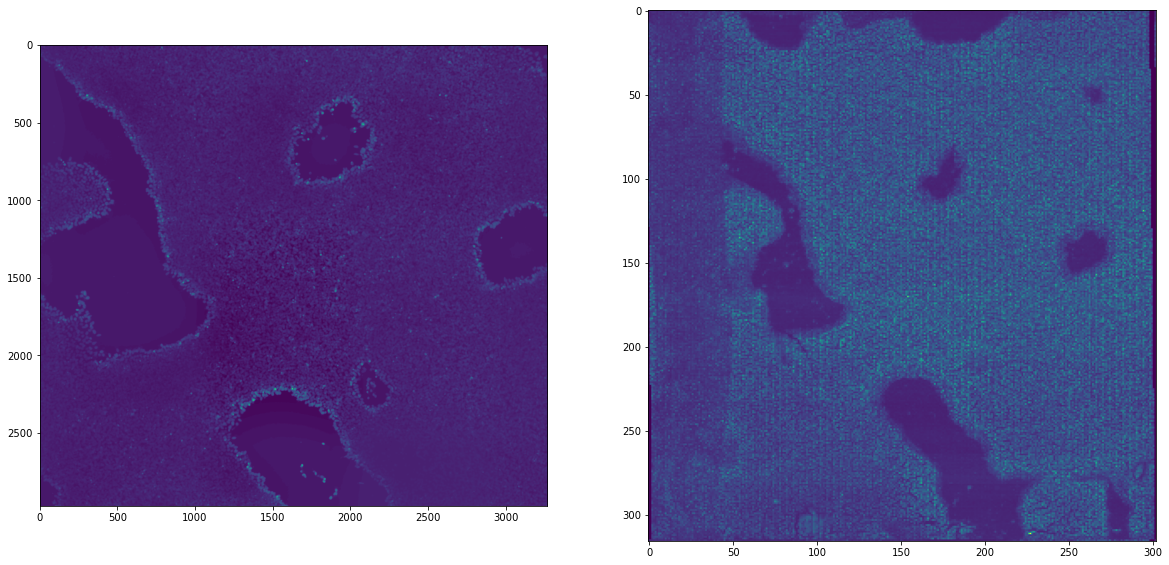

In [2]:
# loading representative images
confocal = cv2.imread(confocal_filename, -1)
maldi = cv2.imread(maldi_filename, 0)
# normalizing image intensities
confocal2 = cv2.normalize(confocal, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
maldi2 = cv2.normalize(maldi, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# applying bluring filters to remove high-frequency noise and bring out the colony outlines
confocal2 = gaussian(median(confocal2,disk(5)),1)
# displaying images after processing  
fig=plt.figure(figsize=(20,20))
fig.add_subplot(1, 2, 1)
plt.imshow(confocal2)
fig.add_subplot(1, 2, 2)
plt.imshow(maldi2)
plt.show()
# initial image dimentions
h_conf, w_conf = confocal2.shape
h_maldi, w_maldi = maldi2.shape
m = h_conf/h_maldi
# resizing confocal to match MALDI height
confocal2 = cv2.resize(confocal2, dsize=(int(w_conf/m),h_maldi))
h_conf_res, w_conf_res = confocal2.shape
# matching the maldi and confocal width by leaving a stripe of zeros on the right for the narrower image 
h, w = max(h_conf_res, h_maldi), max(w_conf_res, w_maldi) # common dimentions after shape matching
if w_conf_res > w_maldi:
    maldi3 = np.zeros((h,w))
    maldi3[:,:w_maldi] = maldi2
    confocal3 = confocal2
else:
    confocal3 = np.zeros((h,w))
    confocal3[:,:w_conf_res] = confocal2
    maldi3 = maldi2   


## Alignment and cropping

[0, 0, 0, 1.4777403666292555]


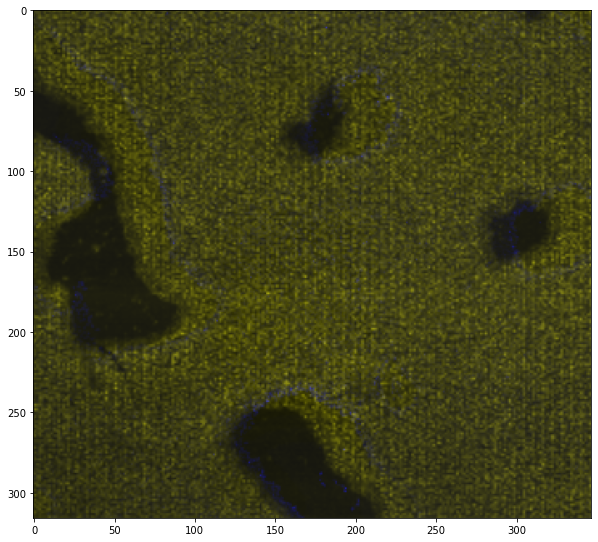

Initial alignment score:  0.07848
Final alignment score:  0.17119
Rotation (rad): -0.00757 X shift: 18.4847 Y shift: -2.5706 Scale: 1.48754


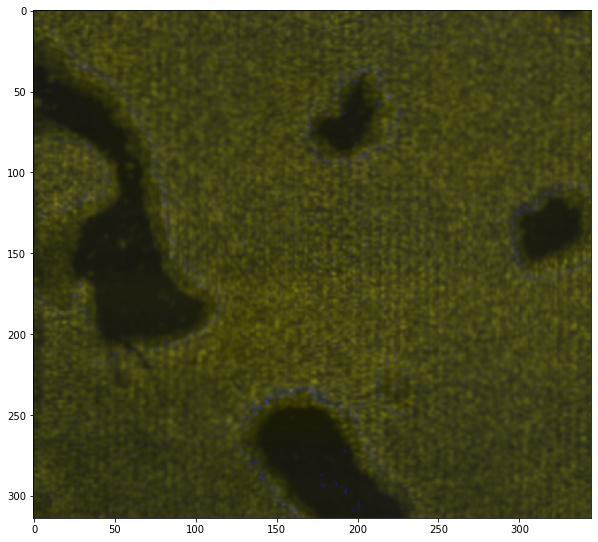

True

In [3]:
xopt[3] = (maldi_pixel_size_um*h_maldi)/(confocal_pixel_size_um*h_conf)
print(xopt)
# take a look at initial alignment, you may adjust initial alignment parameters in the box above
im1,im2 = np.zeros((h,w,3)),np.zeros((h,w,3))
im1[:,:,0] = transform_image(maldi3,xopt[0],xopt[1],xopt[2],xopt[3])
im1[:,:,1] = transform_image(maldi3,xopt[0],xopt[1],xopt[2],xopt[3])
im2[:,:,2] = confocal3
added_image = cv2.addWeighted(im1,1,3*im2,1,0)
fig=plt.figure(figsize=(10,10))
plt.imshow(added_image)
plt.show()
print("Initial alignment score: ",-round(mutual_information(xopt,confocal3,maldi3),5)) 

# alignment by maximizing mutual information:
p_opt = dual_annealing(mutual_information, [(xopt[0]-angle_range,xopt[0]+angle_range),(xopt[1]-x_range,xopt[1]+x_range),(xopt[2]-y_range,xopt[2]+y_range),(xopt[3]-scale_range,xopt[3]+scale_range)],args=(confocal3,maldi3),maxiter=maxiter,initial_temp = 5e4,x0 = xopt)
print("Final alignment score: ",-round(p_opt.fun,5))
print("Rotation (rad):",round(p_opt.x[0],5),"X shift:",round(p_opt.x[1],5),"Y shift:",round(p_opt.x[2],5),"Scale:",round(p_opt.x[3],5))
# take a look at the alignment result
maldi_transf = transform_image(maldi3,p_opt.x[0],p_opt.x[1],p_opt.x[2],p_opt.x[3])
# cropping images for output
[top_maldi,bottom_maldi,left_maldi,right_maldi] = crop(maldi_transf)
[top_confocal,bottom_confocal,left_confocal,right_confocal] = crop(confocal3)
top,bottom = max(top_maldi,top_confocal),min(bottom_maldi,bottom_confocal)
left,right = max(left_maldi,left_confocal),min(right_maldi,right_confocal)
im1,im2 = np.zeros((h,w,3)),np.zeros((h,w,3))
im1[:,:,0] = maldi_transf
im1[:,:,1] = maldi_transf
im2[:,:,2] = confocal3
added_image = cv2.addWeighted(im1,1,3*im2,1,0)
fig=plt.figure(figsize=(10,10))
plt.imshow(added_image[top:bottom,left:right])
plt.show()

# Segmentation

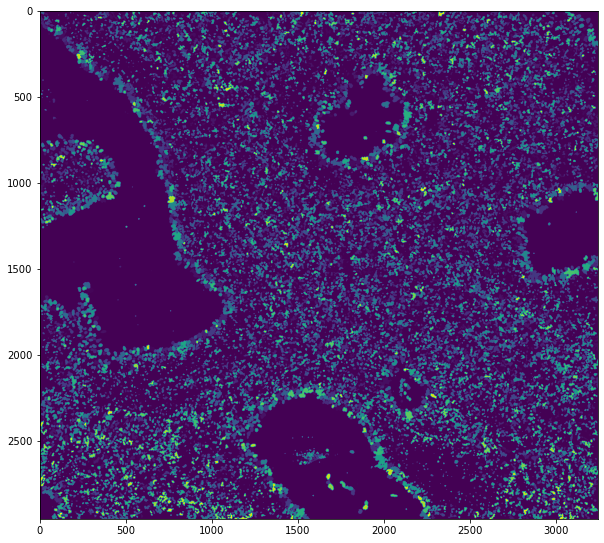

In [6]:
# crop initial DAPI confocal
m = h_conf/h_maldi # multiplier for confocal 
cropped_confocal = confocal[int(m*top):int(bottom*m),int(m*left):int(right*m)] 
h_crop,w_crop = cropped_confocal.shape
# start cell segmentation
# Gaussian filter
If = 255*gaussian(cropped_confocal, sigma=IntensityBlurRad)
mask = threshold_local(If, RadThr, offset = -Thr).astype(np.uint8)
mask = If>mask
# Euclidean distance transformation
distance = ndimage.distance_transform_edt(mask)
distance = gaussian(distance, sigma=DistanceBlurRad)    
local_maxi = peak_local_max(distance, indices=False, min_distance=10, labels=mask)
markers = label(local_maxi)
# Binary watershed
nuclei_labels = watershed(-distance, markers, mask=mask)
fig = plt.figure(figsize=(10,10))
plt.imshow(relabel_random(nuclei_labels))
plt.show()
# calculating cell properties
cellprops = regionprops(nuclei_labels) 
# remove outlier cells with Area deviation > 3*sigma from mean and create scatterplot with cells colored by Area
if not os.path.exists(metrics_output_folder):os.mkdir(metrics_output_folder)
cells, X, Y, area, perimeter, eccentricity = cleanup(cellprops,h_crop,w_crop,metrics_output_folder) 


# Producing output

Produced images:
dapi.tif


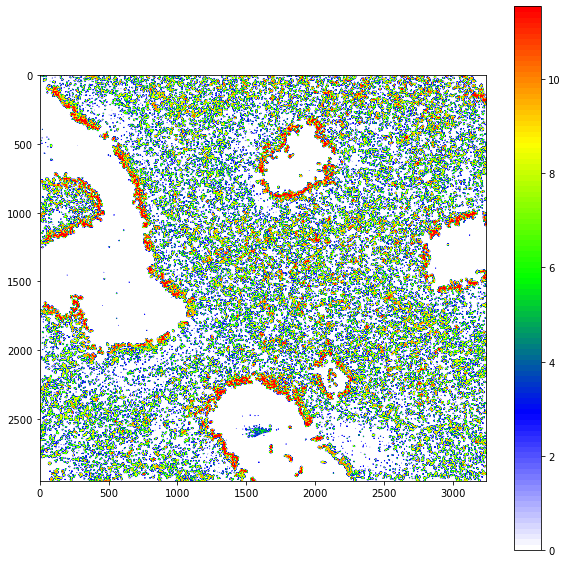

gfp.tif


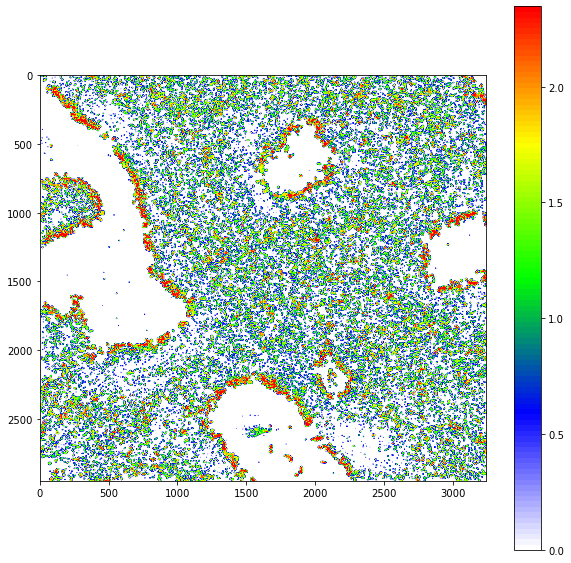

rfp.tif


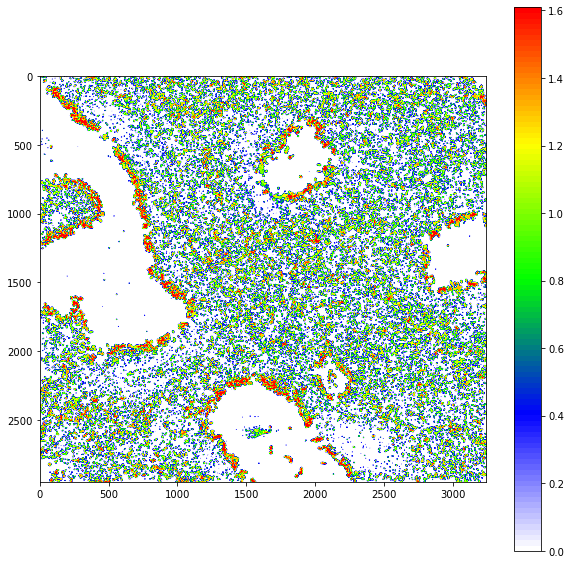

mz 883.576


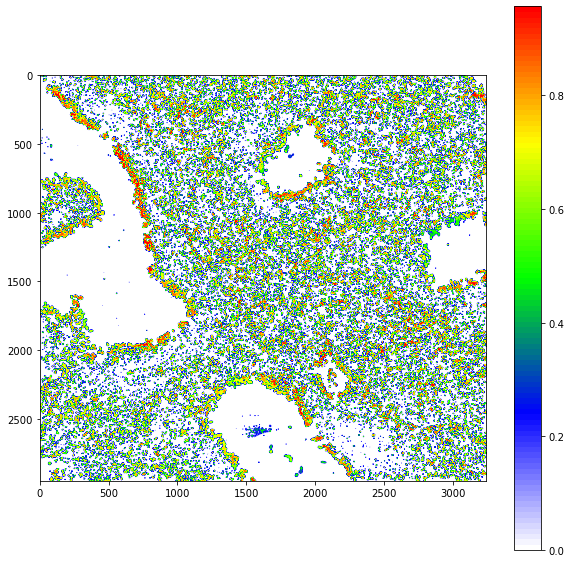

mz 885.573


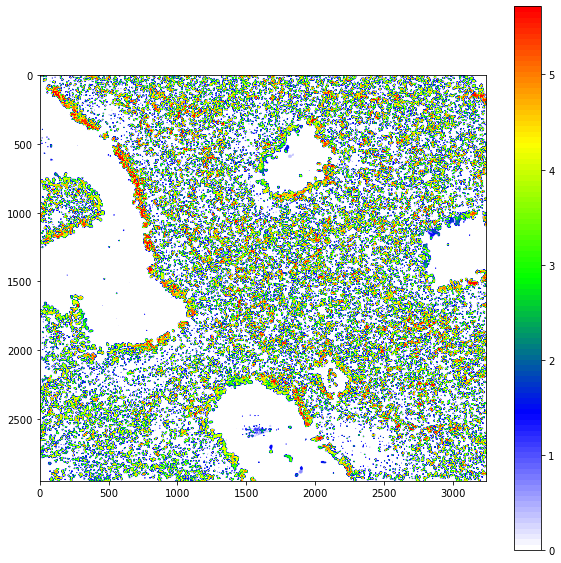

mz 887.57


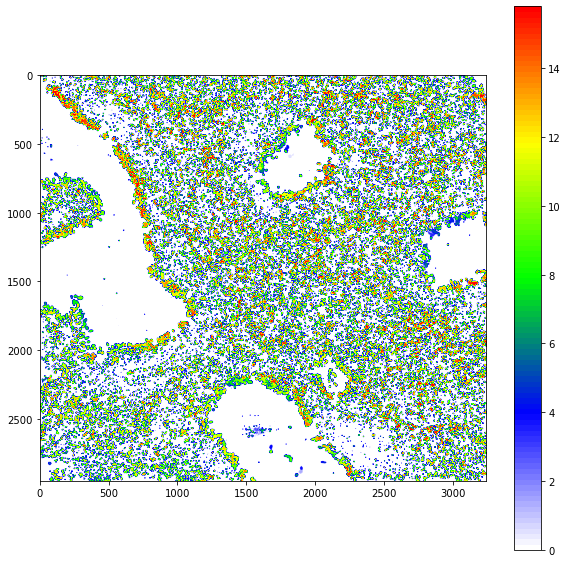

mz 913.597


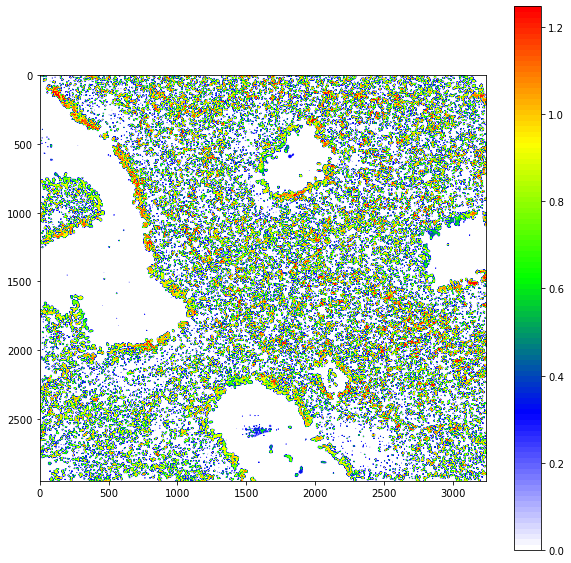

mz 915.594


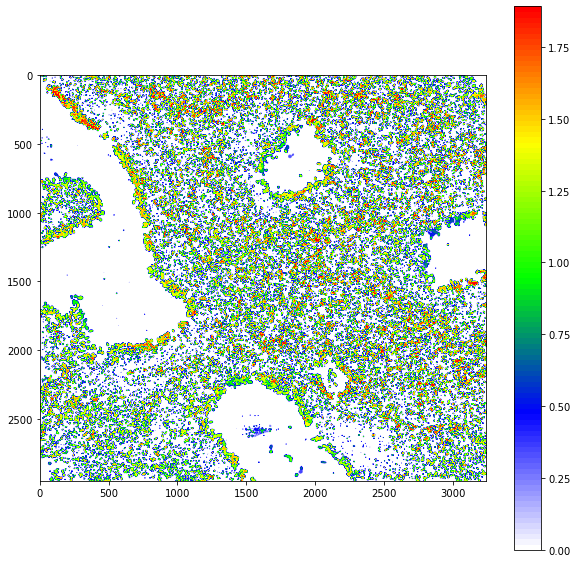

mz 940.592


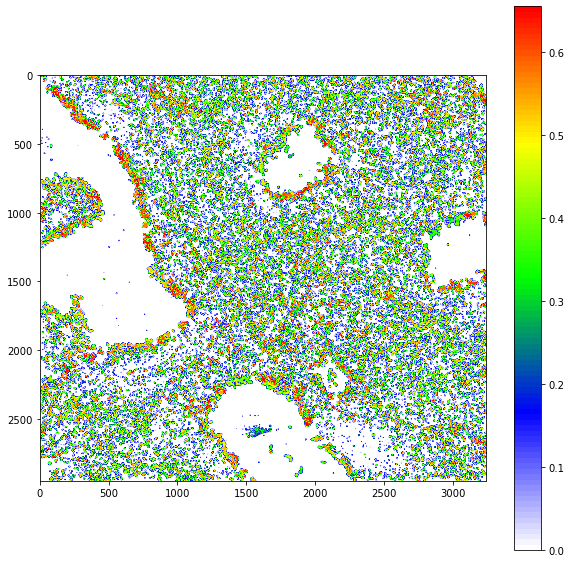

In [22]:

# create output folders 
if not os.path.exists(maldi_output_path):os.mkdir(maldi_output_path)
if not os.path.exists(metrics_output_folder):os.mkdir(metrics_output_folder)    
if not os.path.exists(crop_confocal_path):os.mkdir(crop_confocal_path)
l1 = os.listdir(maldi_folder_path)
l2 = os.listdir(confocal_folder_path)
allowed_formats = [".png",".tif",".jpg",".bmp"]
excel_header= ["X","Y","Area", "Perimeter", "Eccentricity"]
excel_data = [Y,np.max(X)-X, area, perimeter, eccentricity]
print("Produced images:")

for name in l2:
    if name[-4:] not in allowed_formats: continue
    print(name)
    confocal = cv2.imread(confocal_folder_path+"/"+name,-1)
    cropped_confocal = confocal[int(m*top):int(bottom*m),int(m*left):int(right*m)]
    cv2.imwrite(crop_confocal_path+"/"+name,cropped_confocal)
    if name[-4:] != ".tif": continue
    excel_data.append(overlay_cells(cropped_confocal,cells,metrics_output_folder+"/"+name[:-4]+".png")[0])
    excel_header.append(name[:-4])
# output aligned MALDI scaled up to original confocal resolution
ydim,xdim = getimagedimsfromexcel(maldi_folder_path)
for ion in ions:
    name = "mz "+str(ion)
    print(name)
    im = readimagefromexcel(ion,maldi_folder_path,ydim,xdim)
    if w_conf_res > w_maldi:
        im2 = np.zeros((h,w))
        im2[:,:w_maldi] = im
    else:
        im2 = im
    im2 = transform_image(im2,p_opt.x[0],p_opt.x[1],p_opt.x[2],p_opt.x[3])
    im2 = im2[top:bottom,left:right]
    im2 = cv2.resize(im2, dsize=(cropped_confocal.shape[1],cropped_confocal.shape[0]))     
    cv2.imwrite(maldi_output_path+"/"+name+".png",im2)
    excel_data.append(overlay_cells(im2,cells,metrics_output_folder+"/"+name+".png")[0])
    excel_header.append(name)    

# produce Excel output
workbook = xlsxwriter.Workbook(xlsx_output_name)
worksheet = workbook.add_worksheet()
worksheet.write_row(0, 0, excel_header)
for i in range(len(excel_data)):
    worksheet.write_column(1, i, excel_data[i])
workbook.close()


# Cell network metrics

In [12]:
excel_data = np.array(excel_data[5:])
# identifying a distance at which to consider two cells neighbors
connection = get_connection_length(X,Y)
print("connection length = ", round(connection))
region = connection*metrics_range # setting up a distance at which to calculate the rest of the metrics for the cell
d,n = len(excel_data), len(excel_data[0])  # n is total number of cells, d is number of variables
# setting up arrays for metrics
avgLength,density,edge,number_of_conn = np.zeros(n),np.zeros(n),np.zeros(n),np.zeros(n)
edgeDist,centerDist = np.zeros(n),np.zeros(n)
global_neigh_region = []
selfOverAvg, avgCluster, clusterSize, rangeNeigh = np.zeros((n,d)),np.zeros((n,d)),np.zeros((n,d)),np.zeros((n,d))
averageNeigh, stdNeigh, selfOverAvgCluster = np.zeros((n,d)),np.zeros((n,d)),np.zeros((n,d))
# starting to calculate cell-by-cell metrics
percent = int(n/100)
print("Calculating basic metrics:")
print("|---------------------------------------------------------------------------------------------------|")
for i in range(n):
    x, y = X[i], Y[i]
    neigh_region = []
    # define neighborhoods for each cells
    for j in range(n):
        if i == j: continue
        dist = ((X[j]-x)**2+(Y[j]-y)**2)**0.5 # distance between cell i and cell j centers
        if dist < region:
            if dist < connection:
                avgLength[i] += dist
                number_of_conn[i] += 1 # neighbors in the range of 1 cell to cell conection
            neigh_region.append(j) # neighbors in the range of metrics_range cell to cell conection
    # add cell neighborhood
    global_neigh_region.append(neigh_region)
    if number_of_conn[i] != 0: # if cell has some neighbors
        avgLength[i] = avgLength[i]/number_of_conn[i] # average distance to neighbors
        density[i] = number_of_conn[i]/avgLength[i] 
        edge[i] = on_edge(X,Y,i,len(neigh_region),neigh_region,edge_margin) # identify if cell is on the edge
        for p in range(d):
            selfOverAvg[i,p] = excel_data[p,i]/np.mean(excel_data[p,neigh_region])
            if np.mean(excel_data[p,neigh_region]) == 0:
                if excel_data[p,i] == 0: selfOverAvg[i,p] = 1
                else: selfOverAvg[i,p] = 10
            averageNeigh[i,p] = np.mean(excel_data[p,neigh_region])
            stdNeigh[i,p] = np.std(excel_data[p,neigh_region]) 
            rangeNeigh[i,p] = np.max(excel_data[p,neigh_region])-np.min(excel_data[p,neigh_region])
    else: # if the ith cell doesn't have any neighboors
        selfOverAvg[i] = np.ones(d)
        avgLength[i] = connection
        averageNeigh[i] = excel_data[:,i]
        edge[i] = 1
    if i % percent == 0:
        sys.stdout.write("|")
print("\n Basic metrics calculated, starting clustering")

for i in range(d):
    # calculate spatial clusters of each variable
    clusterSize[:,i], avgCluster[:,i] = ClusterImage(averageNeigh[:,i],num_value_layers,X,Y,connection,min_clust_size)
    selfOverAvgCluster[:,i] = averageNeigh[:,i]/avgCluster[:,i]

# calculate distance to the edge
min_edge_dist = 100
for i in range(n):
    if edge[i] == 1: edgeDist[i] = 0    
    else:
        edgeDist[i] = edgeDistance(X,Y,edge,i)
        if min_edge_dist > edgeDist[i]:
            min_edge_dist = edgeDist[i]
# calculate distance to the center
max_center_dist = 1/min_edge_dist**0.25
for i in range(n):
    if edge[i] == 1: centerDist[i] = max_center_dist
    else:
        centerDist[i] = 1/edgeDist[i]**0.25


# produce output
headerString = "X,Y"
metrics_names = ["number of connections","density","average length","edge","distance to edge","distance to center",
                 "_average","_std","_self_value_over_average","_cluster_size","_average_cluster",
                 "_self_value_over_average_cluster","_range"]
metrics = [number_of_conn,density,avgLength,edge+np.ones(n),edgeDist,centerDist,averageNeigh,stdNeigh,selfOverAvg,
           clusterSize,avgCluster,selfOverAvgCluster,rangeNeigh]

for i in range(6):
    visualize(metrics[i], cells, h_crop, w_crop, metrics_output_folder+"/"+metrics_names[i]+".png")
    headerString += ","+metrics_names[i]
for i in range(d):
    name = excel_header[i+5]
    for j in range(6,len(metrics_names)):
        headerString += ","+name+metrics_names[j]
        visualize(metrics[j][:,i], cells, h_crop, w_crop, metrics_output_folder+"/"+name+metrics_names[j]+".png")
# output in the csv format because xlsx gets too heavy with all the metrics
f = open(metrics_output_name,"w")
f.write(headerString+"\n")
for k in range(n):
    s = str(X[k])+","+str(Y[k])
    for i in range(6):
        s += ","+str(metrics[i][k])
    for i in range(d):
        for j in range(6,len(metrics_names)):
            s += ","+str(metrics[j][k,i])
    f.write(s+"\n")

f.close()


NameError: name 'get_connection_length' is not defined